<div style="background:#F5F7FA; height:100px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Want to do more?</span><span style="border: 1px solid #3d70b2;padding: 15px;float:right;margin-right:40px; color:#3d70b2; "><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
<span style="color:#5A6872;"> Try out this notebook with your free trial of IBM Watson Studio.</span>
</div>

# Analyze open data sets with Spark and PixieDust

In this notebook, you'll learn how to use open data from the data sets on the Watson Studio home page in a Python notebook. You will load, and clean the data with Spark DataFrames. You'll explore the data with PixieDust graphs.

Some familiarity with Python is recommended. This notebook runs on Python 2 with Spark 2.0.

The data sets for this notebook are from the World Development Indicators (WDI) data set. The WDI data set is a statistical benchmark that helps measure the progress of human development. The WDI data set draws on data from the World Bank and more than 30 partners. The data contains seven key development variables, sorted by country and year.

## Learning goals

1. Access data from the Watson Studio home page.
1. Merge multiple data sets in Spark DataFrames.
1. Structure data for analysis.
1. Generate summary statistics.
1. Create charts with custom formatting.

## Table of contents
The main parts of this notebook are:
1. [Load data into DataFrames](#load)
    1. [Load the first data set](#first)
    1. [Load another data set](#loadsecond)
    1. [Join the DataFrames](#joindataframes)
    1. [Add more data](#loadmore)  
1. [Check the data](#check)
1. [Analyze the data](#analysis)
    1. [Create graphs with PixieDust](#creategraphs)<br>
1. [Summary and next steps](#summary)

<a id="load"></a>
## 1. Load data into Spark DataFrames via Object Storage

To load the data, you obtain access key links and put them into the code to create a Spark DataFrame. You will load data into multiple DataFrames, merge the DataFrames and create a MultiIndex to structure the data for analysis.

<a id="first"></a>
### A. Load the first data set

The first data set that you'll load contains life expectancy data.

One of the easiest ways to load data into a Spark DataFrame is using Object Storage on Watson Studio, which is what we'll use to load the first data set.
Find the data set and get the download link:
1. Go to this card in the DSX Community: [Life expectancy at birth by country in total years](https://apsportal.ibm.com/exchange/public/entry/view/f15be429051727172e0d0c226e2ce895).
1. Click the download button and save the file.
1. Close the tab and return to your notebook.
1. Click the **Data** (1010) button.
1. Browse for your file, or drag it into the box.
1. After the file loads, click in the next cell, then click **Insert to code > Insert SparkSession DataFrame** below the file name.
1. Change the name of the DataFrame from `df_data_1` to `df_life` in the fifth to last and last lines.
1. Run the cell. 

In [21]:
# click here and then Insert to code > Insert SparkSession DataFrame


[Row(Country or Area=u'Afghanistan', Year=u'2012', Value=u'60.5091219512195', Value Footnotes=None),
 Row(Country or Area=u'Afghanistan', Year=u'2011', Value=u'60.0653658536585', Value Footnotes=None),
 Row(Country or Area=u'Afghanistan', Year=u'2010', Value=u'59.6000975609756', Value Footnotes=None),
 Row(Country or Area=u'Afghanistan', Year=u'2009', Value=u'59.1123414634146', Value Footnotes=None),
 Row(Country or Area=u'Afghanistan', Year=u'2008', Value=u'58.6070975609756', Value Footnotes=None)]

Now let's format the data. First use `registerDataFrameAsTable()` to rename columns and convert the DataFrame to a table named `df_life`. As you only need a subset of the columns, use `sqlContext.sql()` to return values for the country, year, and population total. To make sure that the values are numeric use `.cast("double")`. Use the `createOrReplaceTempView()` method for easy data access and transformation later on. Finally, preview the data to make sure everything looks correct using `show()`.

In [2]:
sqlContext.registerDataFrameAsTable(df_life, "myTable")
df_life = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Life FROM myTable")

df_life = df_life.withColumn("Life", df_life["Life"].cast("double"))
                                            
df_life.createOrReplaceTempView('life')
df_life.show(10)

+-----------+----+----------------+
|    Country|Year|            Life|
+-----------+----+----------------+
|Afghanistan|2012|60.5091219512195|
|Afghanistan|2011|60.0653658536585|
|Afghanistan|2010|59.6000975609756|
|Afghanistan|2009|59.1123414634146|
|Afghanistan|2008|58.6070975609756|
|Afghanistan|2007|58.0913658536585|
|Afghanistan|2006|57.5706585365854|
|Afghanistan|2005|57.0584390243903|
|Afghanistan|2004|56.5697317073171|
|Afghanistan|2003|56.1075609756098|
+-----------+----+----------------+
only showing top 10 rows



<a id="loadsecond"></a>
### B. Load another data set

The life expectancy figures are more meaningful if you combine them with other data sets. Another way to load data into a Spark DataFrame is by using [PixieDust](https://ibm-watson-data-lab.github.io/pixiedust/), a powerful Python package with a wide range of capabilities. The PixieDust library is installed on Watson Studio, so you just need to import it.

In [3]:
import pixiedust

Pixiedust database opened successfully


If you get a message that you need to upgrade PixieDust, remove the `#` and run the following cell, restart your kernel from the **Kernel** menu, and then rerun the previous cells to reload the data and to import PixieDust.

In [ ]:
# !pip install --user --upgrade pixiedust

You can access data easily with the PixieDust `sampleData()` method:
1. Go to the card on the Watson Studio community: [Total population by country](https://apsportal.ibm.com/exchange/public/entry/view/889ca053a19986a4445839358a91963e).
1. Click the link button and copy the Data Access Link.
1. In the next cell, replace the text `DATA ACCESS LINK` in the `sampleData` function with the data access link. 

In [ ]:
# replace DATA ACCESS LINK with your data access link
df_pop = pixiedust.sampleData('DATA ACCESS LINK')

As before register the DataFrame as the `population` table and include only the country, year, and population value in the table. Then create a local temporary view `population` to use later.

In [5]:
sqlContext.registerDataFrameAsTable(df_pop, "PopTable")
df_pop = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Population FROM PopTable")
df_pop.createOrReplaceTempView('population')
df_pop.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Population: long (nullable = true)



In [6]:
df_pop.show(10)

+-----------+----+----------+
|    Country|Year|Population|
+-----------+----+----------+
|Afghanistan|2013|  30551674|
|Afghanistan|2012|  29824536|
|Afghanistan|2011|  29105480|
|Afghanistan|2010|  28397812|
|Afghanistan|2009|  27708187|
|Afghanistan|2008|  27032197|
|Afghanistan|2007|  26349243|
|Afghanistan|2006|  25631282|
|Afghanistan|2005|  24860855|
|Afghanistan|2004|  24018682|
+-----------+----+----------+
only showing top 10 rows



Find out how many countries are listed in the `life` and `population` tables by collecting the unique country names in each:  

In [7]:
print "number of countries in life:", spark.sql('SELECT COUNT(DISTINCT Country) from life').collect()[0][0]

print "number of countries in population:", spark.sql('SELECT COUNT(DISTINCT Country) from population').collect()[0][0]

number of countries in life: 246
number of countries in population: 245


<a id="joindataframes"></a>
### C. Join DataFrames

As you can see, the two data sets do not fit together perfectly: one contains more countries than the other. When you join two DataFrames, it is common to introduce nulls or NaNs (a value that is not a number when a number is expected) into the resulting DataFrame.

Use the `join` function to merge the data together. The first parameter is the name of the DataFrame to add, next is the fields to join the two DataFrames on, and third is the kind of join to perform. In this case, you want to do an outer join to keep the data from both `df_life` and `df_pop`. Here the join is done on both the `Country` and `Year` columns. To see more options for the `join` function, see <a href="http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html?highlight=join#pyspark.sql.DataFrame.join" target="_blank" rel="noopener no referrer">Joins in Spark</a>. 

In [8]:
df_life_pop = df_life.join(df_pop, ['Country', 'Year'], 'outer').orderBy(['Country', 'Year'], ascending=True)
df_life_pop.show(10)

+-----------+--------------------+----------------+----------+
|    Country|                Year|            Life|Population|
+-----------+--------------------+----------------+----------+
|          2|Derived using lin...|            null|      null|
|          3|Derived using lin...|            null|      null|
|          4|Derived using ext...|            null|      null|
|          5|Derived using int...|            null|      null|
|          6|Derived using ext...|            null|      null|
|          7|Derived using lin...|            null|      null|
|          8|Derived using pre...|            null|      null|
|Afghanistan|                1960|31.5800487804878|   8774440|
|Afghanistan|                1961|32.0959756097561|   8953544|
|Afghanistan|                1962|32.6118780487805|   9141783|
+-----------+--------------------+----------------+----------+
only showing top 10 rows



<a id="loadmore"></a>
### D. Add more data

Add more country related data to the DataFrame. For each data se include the country and year columns, plus a column that contains the key variable for that data set. For the employment data set, derive a column from three original columns.

While logged in to your Watson Studio account, click each of the following links to get data access links, and paste them into the appropriate sections of the following cell:
* [Population below national poverty line, total, percentage](https://apsportal.ibm.com/exchange/public/entry/view/3a42de810e682d5a83e76fda9fea2bbe)
* [Primary school completion rate % of relevant age group by country](https://apsportal.ibm.com/exchange/public/entry/view/97fc6c420265012ae9b5e9439b9ee293)
* [Total employment, by economic activity (Thousands)](https://apsportal.ibm.com/exchange/public/entry/view/21c789ae4cfadf52f1bb14b5d4a0b99c)
* [Births attended by skilled health staff (% of total) by country](https://apsportal.ibm.com/exchange/public/entry/view/87160cc8374805cb3b07dff4b4f9223e)
* [Measles immunization % children 12-23 months by country](https://apsportal.ibm.com/exchange/public/entry/view/752e36ea889eca360e989baa785c2a5e)

Then run the cell.

In [ ]:
df_NPL = pixiedust.sampleData('DATA ACCESS LINK FOR POVERTY')
sqlContext.registerDataFrameAsTable(df_NPL, "NPLTable")
df_NPL = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Poverty FROM NPLTable")

df_school = pixiedust.sampleData('DATA ACCESS LINK FOR SCHOOLS')
sqlContext.registerDataFrameAsTable(df_school, "SchoolTable")
df_school = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as School FROM SchoolTable")

df_econ = pixiedust.sampleData('DATA ACCESS LINK FOR EMPLOYMENT')
sqlContext.registerDataFrameAsTable(df_econ, "EconTable")
df_econ = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Employment FROM EconTable WHERE Subclassification='Total.'")

df_birth = pixiedust.sampleData('DATA ACCESS LINK FOR BIRTHS')
sqlContext.registerDataFrameAsTable(df_birth, "BirthTable")
df_birth = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Birth FROM BirthTable")

df_measles = pixiedust.sampleData('DATA ACCESS LINK FOR MEASLES')
sqlContext.registerDataFrameAsTable(df_measles, "MeaslesTable")
df_measles = sqlContext.sql("SELECT `Country or Area` as Country, Year, Value as Measles FROM MeaslesTable")

df_total = df_life.join(df_pop, ['Country', 'Year'], 'outer')\
    .join(df_NPL, ['Country', 'Year'], 'outer')\
    .join(df_school, ['Country', 'Year'], 'outer')\
    .join(df_econ, ['Country', 'Year'], 'outer')\
    .join(df_birth, ['Country', 'Year'], 'outer')\
    .join(df_measles, ['Country', 'Year'], 'outer')\
    .orderBy(['Country', 'Year'], ascending=True)

In [10]:
df_total.show(10)

+-------+----+----+----------+-------+------+----------+-----+-------+
|Country|Year|Life|Population|Poverty|School|Employment|Birth|Measles|
+-------+----+----+----------+-------+------+----------+-----+-------+
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
|   null|null|null|      null|   null|  null|      null| null|   null|
+-------+----+----+----------+-------+------+----------+-----+-------+
only s

The resulting table looks strange because some records contain incorrect values, such as numbers in the `country` column and text in the `year` column. Run the following cell to convert the years to integers and delete rows with no from the DataFrame:

In [13]:
df_total = df_total.withColumn("Year", df_total["Year"].cast("integer"))
df_total.createOrReplaceTempView('fixed_total')
df_fixed_total = spark.sql("SELECT * FROM fixed_total WHERE Country is not NULL AND Year is not NULL")
df_fixed_total.show(100)

+-----------+----+----------------+----------+-------+--------+----------+-----+-------+
|    Country|Year|            Life|Population|Poverty|  School|Employment|Birth|Measles|
+-----------+----+----------------+----------+-------+--------+----------+-----+-------+
|Afghanistan|1960|31.5800487804878|   8774440|   null|    null|      null| null|   null|
|Afghanistan|1961|32.0959756097561|   8953544|   null|    null|      null| null|   null|
|Afghanistan|1962|32.6118780487805|   9141783|   null|    null|      null| null|   null|
|Afghanistan|1963|33.1273170731707|   9339507|   null|    null|      null| null|   null|
|Afghanistan|1964| 33.641243902439|   9547131|   null|    null|      null| null|   null|
|Afghanistan|1965|34.1536829268293|   9765015|   null|    null|      null| null|   null|
|Afghanistan|1966|34.6631219512195|   9990125|   null|    null|      null| null|   null|
|Afghanistan|1967|35.1700731707317|  10221902|   null|    null|      null| null|   null|
|Afghanistan|1968|35.

In [14]:
print "number of rows:", df_fixed_total.count()

number of rows: 18752


You can see that for the 1980s, the only data for Afghanistan is about measles immunizations.

If you are curious about other variables, you can add more WDI data sets from the Watson Studio home page to this DataFrame. Not all WDI data is properly formatted. You might need to clean the data before you add it. You can reuse the code samples that you just ran. Make sure that you keep checking the results by running commands like `df.show()` on your tables when you load or change them. 

<a id="check"></a>
## 2. Check the data 
You can check the data with <a href="http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrame.describe" target="_blank" rel="noopener noreferrer">`describe()`</a>, which calculates basic summary statistics for each of the columns in the DataFrame (except the country and year columns). 

Run the following cell to show the number of values (count), the mean, the standard deviation (std), the minimum value, and the maximum value for the columns:  

In [15]:
df_fixed_total.printSchema()
describe = df_fixed_total.describe()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Life: double (nullable = true)
 |-- Population: long (nullable = true)
 |-- Poverty: double (nullable = true)
 |-- School: double (nullable = true)
 |-- Employment: double (nullable = true)
 |-- Birth: double (nullable = true)
 |-- Measles: double (nullable = true)



In [16]:
display(describe)

summary,Country,Year,Life,Population,Poverty,School,Employment,Birth,Measles
count,18752,18752,16384,17571,1119,7508,7788,2461,10424
mean,None,1988.59902943686,65.6410197219434,1.1218677059507142E8,30.708411411617515,81.97120813066316,8420.035129804444,86.66069703600967,78.7565499969908
stddev,None,14.502494093547401,10.950710140307564,4.7442477133428013E8,17.32670409116816,23.432827760246916,35957.05527582198,22.161432550771895,20.96691338208919
min,Afghanistan,1960,19.5049268292683,4279,1.7,1.52203,0.276,5.0,1.0
max,Zimbabwe,2014,83.4804878048781,7124543962,96.0,193.26334,737400.0,100.0,99.0


<a id="analysis"></a>
## 3. Analyze the data
Now that there is enough sample data to work with, you can start analyzing the data. 

<a id="creategraphs"></a>
### A. Create graphs with PixieDust

PixieDust makes generating visualizations fast and easy, and allows you to change them on the fly. Run the `display()` command on your DataFrame to visualize your data using PixieDust.  

One interesting question to explore with this data is why there is a difference in Life Expectancy at Birth. Let's first explore this data.  

Run the `display()` command and then configure the graph:
1. Run the next cell. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Histogram**. The chart options tool appears.
1. In the chart options tool, drag `life` into the **Values** box. 
1. Increase the **# of Rows to Display** to 20,000 to display all the data, and click **OK**. The chart appears.

If you want to make further changes, click **Options** to return to the chart options tool. Make sure you check out the different renderers from the drop-down menu on the right of the chart. 

In [17]:
display(df_fixed_total)

The histogram shows that there is a large variation in life expectancy between countries and over the years: from 30 to over 80 years. 

Have a look at where these countries are with a map. 

Run the `display()` command and then configure the map:
1. Run the next cell. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Map**. The chart options tool appears.
1. In the chart options tool, drag `Life` into the **Values** box. 
1. Move `Country` into the **Keys** box.
1. Increase the **# of Rows to Display** to 20,000 to display all the data.
1. Select AVG to show the average life expectancy over all years for each country and click **OK**. The map appears.

You can scroll over the map to see the name of the country and the average life expectancy.

In [18]:
display(df_fixed_total)

As expected, the life expectancy is lowest in Africa, and highest in the US and Europe. Maybe one of the other variables in the `df_fixed_total` DataFrame can explain this. 

You can make maps of all variables or explore this question with scatter plots.

Run the `display()` command below and then configure the graph:
1. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Scatter Plot**. The chart options tool appears.
1. In the chart options tool, drag all values except `year` into the **Values** box. 
1. Move `year` into the **Keys** box and click **OK**. The chart appears.



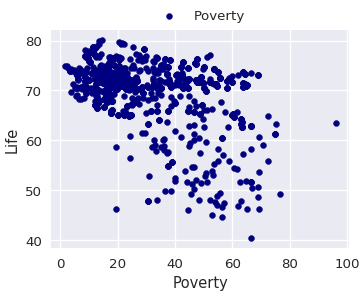

In [19]:
display(df_fixed_total)

There seems to be a trend: decrease of life expectancy with an increase of poverty. Because there are a lot of point per country and the main question is what causes the difference in life expectancy between countries, create a new DataFrame with only one average value for each country. 

Group all data by country using the `groupBy()` method. Then recreate the previous scatter plot with this new data.


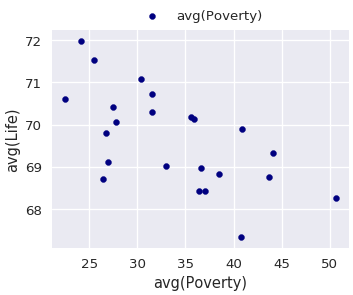

In [20]:
df_by_country = df_fixed_total.groupBy('Year').avg()
display(df_by_country)

This scatter plot shows much more clearly that the life expectancy decreases with an increase of poverty. In a similar way, you can now explore all other variables by creating more maps and charts with PixieDust.  

<a id="summary"></a>
## Summary and next steps
You are now deriving insights from the data and can build a statistical model with this data. For example, try a  <a href="https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#linear-regression" target="_blank" rel="noopener noreferrer">inear regressionOS)</a>[l]() to find which one of the variables explains most of the variation in life expectancy between countries.

As you can see from this sample notebook, data analysis entails a lot of trial and error, and the data needs quite a bit of cleaning up. This experimentation can be challenging, but also a lot of fun!

### Authors

**Christian Johnson** is a Data Scientist Intern at IBM. He has a background in software development and data analysis. Though he still has much to learn about data science, he leverages his skills and experience to support the team's data science initiatives.

**Margriet Groenendijk** is a Data Scientist and Developer Advocate at IBM. She has a background in Geography and Climate Science and now she uses this knowledge to create models and visualizations from diverse data sets using cloud databases, data warehouses, Spark, and Python notebooks.   

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.